In [ ]:
# Install necessary libraries
!pip install -q tensorflow-addons transformers einops

In [ ]:
!pip install tensorflow.keras

In [ ]:
!pip install tensorflow==2.15 keras==2.15 tensorflow-addons

In [ ]:
!pip install keras_cv

In [ ]:
pip install keras-cv

In [ ]:
import os
import zipfile

# Define paths
ZIP_PATH = "/content/gesture_dataset.zip"  # Ensure this matches the file's actual location
EXTRACT_PATH = "/content/gesture_dataset"  # Folder where dataset will be extracted

# Unzip the file
if os.path.exists(ZIP_PATH):
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)
    print(f"✅ Successfully extracted to {EXTRACT_PATH}")
else:
    print("❌ Zip file not found. Check the file path.")


❌ Zip file not found. Check the file path.


In [ ]:
from google.colab import drive
import os
import zipfile

# ✅ MOUNT GOOGLE DRIVE
drive.mount('/content/drive')

# ✅ SET FILE PATHS
zip_path = "/content/drive/MyDrive/DexhandData/gesture_dataset.zip"
extract_path = "/content/gesture_dataset/gesture_dataset"

# ✅ CHECK IF ALREADY EXTRACTED
if not os.path.exists(extract_path):
    print("Extracting dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("/content/")
    print("✅ Dataset extracted successfully!")
else:
    print("✅ Dataset already extracted.")


Mounted at /content/drive
Extracting dataset...
✅ Dataset extracted successfully!


In [ ]:
# === IMPORT LIBRARIES ===
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import VideoMAEModel, VideoMAEConfig
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import os
import pandas as pd
from sklearn.model_selection import train_test_split

📂 Loading dataset...
✅ Dataset Loaded: 5200 samples found
Preprocessing and caching data...
Cached preprocessed data to cached_gesture_data.pt
🔹 Cached Train Set: 4160 samples
🔹 Cached Validation Set: 520 samples
🔹 Cached Test Set: 520 samples


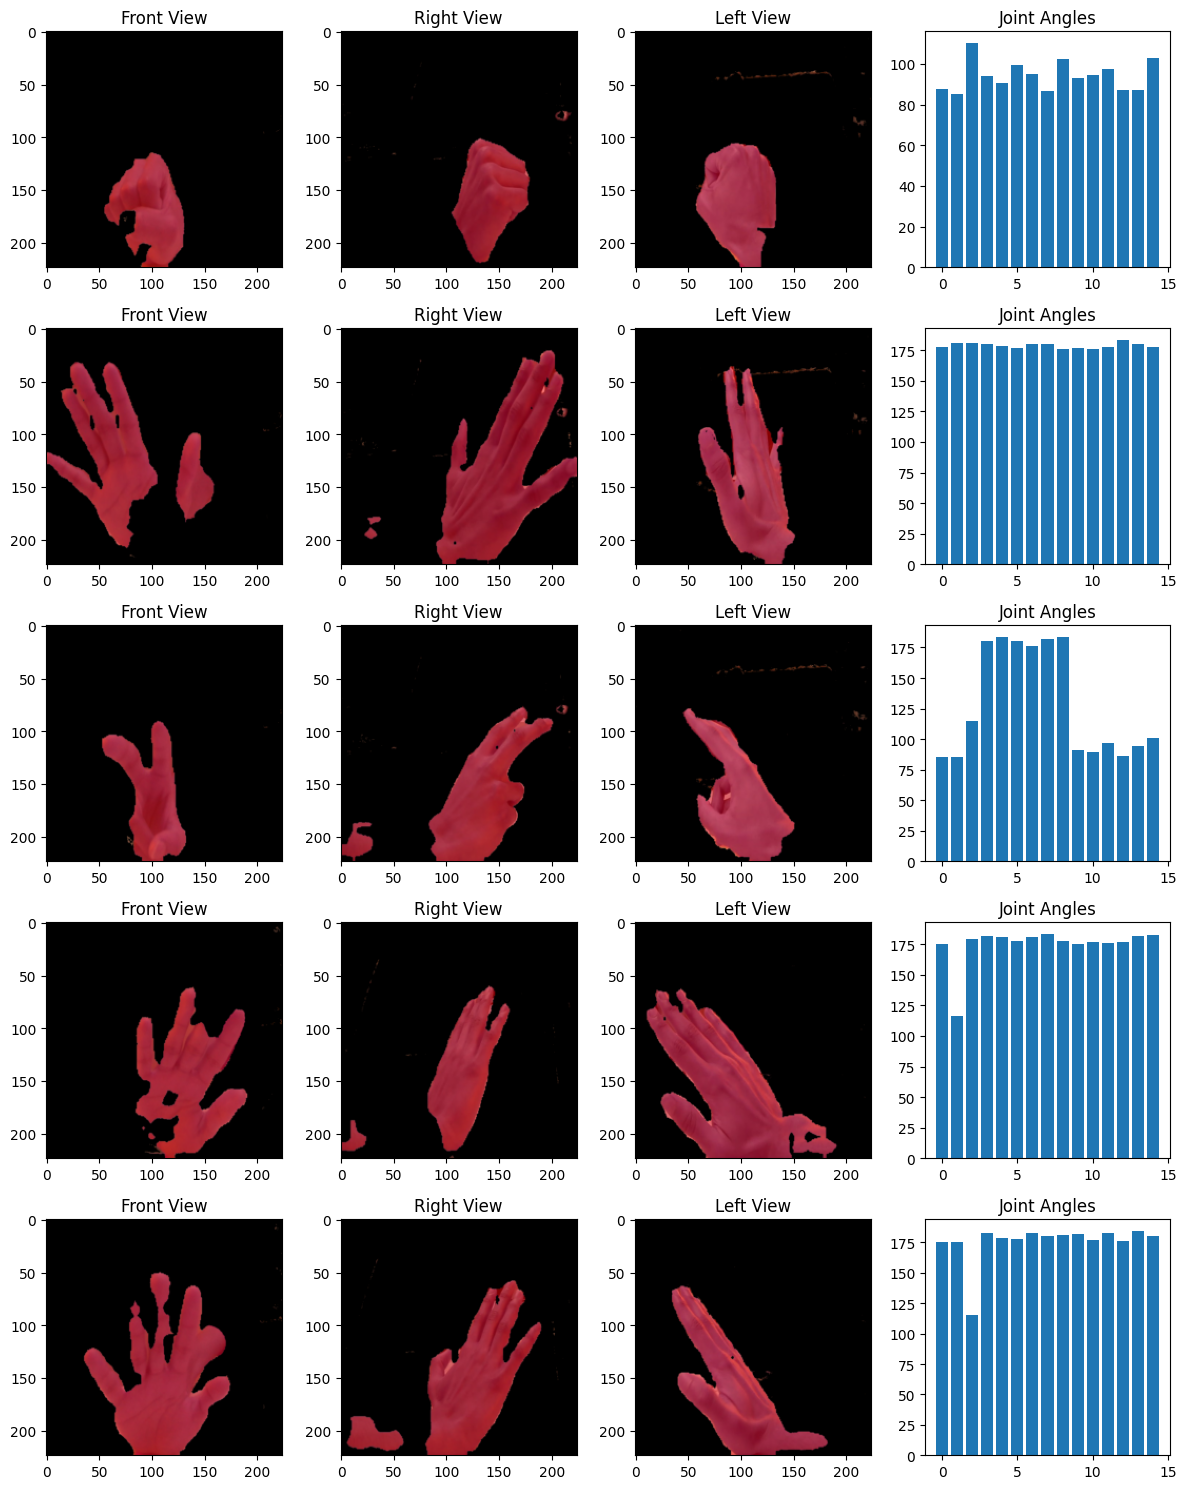

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import os
from PIL import Image
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ===============================
# ✅ CONFIGURATION
# ===============================
DATASET_PATH = "/content/gesture_dataset"
BATCH_SIZE = 64
IMAGE_SIZE = (224, 224)
NUM_JOINTS = 15
ACCURACY_THRESHOLD = 5  # ±5° accuracy range

# Path for caching preprocessed data
CACHE_FILE = "cached_gesture_data.pt"

# ===============================
# ✅ HAND SEGMENTATION FUNCTION
# ===============================
def extract_hand_region(segmented_image_path):
    """Extracts only the hand region from a segmented image using HSV thresholding."""
    image = cv2.imread(segmented_image_path)
    if image is None:
        print(f"❌ Warning: Could not read {segmented_image_path}")
        return np.zeros((224, 224, 3), dtype=np.uint8), np.zeros((224, 224), dtype=np.uint8)

    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_red1 = np.array([0, 120, 70])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 120, 70])
    upper_red2 = np.array([180, 255, 255])

    mask1 = cv2.inRange(image_hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(image_hsv, lower_red2, upper_red2)
    hand_mask = cv2.bitwise_or(mask1, mask2)

    hand_extracted = cv2.bitwise_and(image, image, mask=hand_mask)
    return hand_extracted, hand_mask

# ===============================
# ✅ ORIGINAL DATASET DEFINITION
# ===============================
class GestureDataset(Dataset):
    def __init__(self, dataset_path, transform=None):
        self.dataset_path = dataset_path
        self.transform = transform
        self.data = []

        print("📂 Loading dataset...")

        gesture_folders = sorted(glob.glob(os.path.join(dataset_path, "gesture_*")))
        for gesture_folder in gesture_folders:
            angles_csv = os.path.join(gesture_folder, "angles.csv")
            if not os.path.exists(angles_csv):
                print(f"⚠️ Skipping {gesture_folder} (No angles.csv found)")
                continue

            df = pd.read_csv(angles_csv)
            for _, row in df.iterrows():
                frame_id = int(row["Frame"])
                joint_angles = row.iloc[1:].values.astype(float)

                seg_front = os.path.join(gesture_folder, f"frame_{frame_id:03d}_front_segmented.jpg")
                seg_right = os.path.join(gesture_folder, f"frame_{frame_id:03d}_right_segmented.jpg")
                seg_left = os.path.join(gesture_folder, f"frame_{frame_id:03d}_left_segmented.jpg")

                if os.path.exists(seg_front) and os.path.exists(seg_right) and os.path.exists(seg_left):
                    self.data.append((seg_front, seg_right, seg_left, joint_angles))

        print(f"✅ Dataset Loaded: {len(self.data)} samples found")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seg_front, seg_right, seg_left, joint_angles = self.data[idx]

        hand_front, _ = extract_hand_region(seg_front)
        hand_right, _ = extract_hand_region(seg_right)
        hand_left, _ = extract_hand_region(seg_left)

        hand_front = Image.fromarray(cv2.cvtColor(hand_front, cv2.COLOR_BGR2RGB))
        hand_right = Image.fromarray(cv2.cvtColor(hand_right, cv2.COLOR_BGR2RGB))
        hand_left = Image.fromarray(cv2.cvtColor(hand_left, cv2.COLOR_BGR2RGB))

        if self.transform:
            hand_front = self.transform(hand_front)
            hand_right = self.transform(hand_right)
            hand_left = self.transform(hand_left)

        # Concatenate the three views into one tensor with 9 channels
        images = torch.cat([hand_front, hand_right, hand_left], dim=0)  # Shape: [9, 224, 224]

        return images, torch.tensor(joint_angles, dtype=torch.float32)

# ===============================
# ✅ DATA TRANSFORMATIONS
# ===============================
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create the original dataset
dataset = GestureDataset(DATASET_PATH, transform)

# ===============================
# ✅ PREPROCESS & CACHE THE DATA
# ===============================
if os.path.exists(CACHE_FILE):
    print(f"Loading cached data from {CACHE_FILE}...")
    cached_data = torch.load(CACHE_FILE)
else:
    print("Preprocessing and caching data...")
    cached_data = []
    # Iterate over all samples to run segmentation only once per sample
    for i in range(len(dataset)):
        sample = dataset[i]
        cached_data.append(sample)
    torch.save(cached_data, CACHE_FILE)
    print(f"Cached preprocessed data to {CACHE_FILE}")

# ===============================
# ✅ CACHED DATASET DEFINITION
# ===============================
class CachedGestureDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

cached_dataset = CachedGestureDataset(cached_data)

# ===============================
# ✅ SPLITTING THE CACHED DATASET
# ===============================
train_size = int(0.8 * len(cached_dataset))
val_size = int(0.1 * len(cached_dataset))
test_size = len(cached_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(cached_dataset, [train_size, val_size, test_size])

print(f"🔹 Cached Train Set: {len(train_dataset)} samples")
print(f"🔹 Cached Validation Set: {len(val_dataset)} samples")
print(f"🔹 Cached Test Set: {len(test_dataset)} samples")

# ===============================
# ✅ CREATING DATALOADERS FROM THE CACHED DATASET
# ===============================
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ===============================
# ✅ DEBUG: VISUALIZE SAMPLE DATA FROM CACHED DATASET
# ===============================
def visualize_samples(dataset, num_samples=5):
    """
    Displays segmented hand images along with joint angles.
    """
    fig, axes = plt.subplots(num_samples, 4, figsize=(12, num_samples * 3))
    for i in range(num_samples):
        images, angles = dataset[i]
        front_img = images[:3].permute(1, 2, 0).numpy() * 0.5 + 0.5  # De-Normalize
        right_img = images[3:6].permute(1, 2, 0).numpy() * 0.5 + 0.5
        left_img = images[6:9].permute(1, 2, 0).numpy() * 0.5 + 0.5

        axes[i, 0].imshow(front_img)
        axes[i, 0].set_title("Front View")
        axes[i, 1].imshow(right_img)
        axes[i, 1].set_title("Right View")
        axes[i, 2].imshow(left_img)
        axes[i, 2].set_title("Left View")
        axes[i, 3].bar(range(NUM_JOINTS), angles.numpy())
        axes[i, 3].set_title("Joint Angles")
    plt.tight_layout()
    plt.show()

# Display 5 sample images and their joint angles from the cached training dataset
visualize_samples(train_dataset, num_samples=5)


In [ ]:
from torch.utils.data import DataLoader, random_split

# Assume CACHE_FILE and CachedGestureDataset are defined from previous caching code:
# For example:
# CACHE_FILE = "cached_gesture_data.pt"
# cached_data = torch.load(CACHE_FILE)
# cached_dataset = CachedGestureDataset(cached_data)

# Split the cached dataset: 80% train, 10% validation, 10% test
total_samples = len(cached_dataset)
train_size = int(0.8 * total_samples)
val_size = int(0.1 * total_samples)
test_size = total_samples - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(cached_dataset, [train_size, val_size, test_size])

print(f"Cached Train Set: {len(train_dataset)} samples")
print(f"Cached Validation Set: {len(val_dataset)} samples")
print(f"Cached Test Set: {len(test_dataset)} samples")

# Create DataLoaders without re-running the segmentation
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Cached Train Set: 4160 samples
Cached Validation Set: 520 samples
Cached Test Set: 520 samples


In [ ]:
# Fetch one sample from the cached dataset
sample_images, sample_angles = cached_dataset[0]

print("Sample image shape:", sample_images.shape)  # Expected: torch.Size([9, 224, 224])
print("Sample joint angles shape:", sample_angles.shape)  # Expected: torch.Size([15])


Sample image shape: torch.Size([9, 224, 224])
Sample joint angles shape: torch.Size([15])


In [ ]:
pip install timm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 921.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 480.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 28.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

In [ ]:
# Check GPU and RAM availability
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
if ram_gb < 20:
    print('Not using a high-RAM runtime')
else:
    print('You are using a high-RAM runtime!')

# =============================================================================
# MODEL TRAINING CODE USING MOBILENETV2 (Lightweight for Hands)
# =============================================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import timm  # For pretrained models
import os

# ===============================
# ✅ CONFIGURATION
# ===============================
BATCH_SIZE = 64
ACCURACY_THRESHOLD = 5  # ±5° threshold
NUM_JOINTS = 15
NUM_EPOCHS = 50
LR = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===============================
# ✅ MOBILENETV2 MODEL DEFINITION FOR HAND POSE
# ===============================
class MobileNetV2HandRegressor(nn.Module):
    """
    Uses a pretrained MobileNetV2 from timm, modified to accept 9 input channels
    (for 3 segmented views) and output 15 joint angles.
    """
    def __init__(self, num_joints=15):
        super().__init__()
        self.model = timm.create_model(
            "mobilenetv2_100",      # You can experiment with other variants
            pretrained=True,
            in_chans=9,             # 9 channels: 3 views × 3 channels each
            num_classes=num_joints  # Final output: 15 joint angles
        )

    def forward(self, x):
        return self.model(x)

# ===============================
# ✅ ACCURACY FUNCTION
# ===============================
def compute_accuracy(preds, targets, threshold=ACCURACY_THRESHOLD):
    """
    Percentage of predicted joint angles within ±threshold of ground truth.
    preds, targets: [batch_size, NUM_JOINTS]
    """
    within_thresh = (torch.abs(preds - targets) < threshold).float()
    return (within_thresh.mean() * 100).item()

# ===============================
# ✅ DATASET & DATALOADERS
# ===============================
# Assuming 'cached_dataset' is already loaded (with preprocessed 9-channel images and 15 joint angles)
# For example, your cached_dataset might be a Torch dataset instance you created earlier.
total_samples = len(cached_dataset)
train_size = int(0.8 * total_samples)
val_size = int(0.1 * total_samples)
test_size = total_samples - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(cached_dataset, [train_size, val_size, test_size])
print(f"Cached Train Set: {len(train_dataset)} samples")
print(f"Cached Validation Set: {len(val_dataset)} samples")
print(f"Cached Test Set: {len(test_dataset)} samples")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ===============================
# ✅ TRAINING LOOP (MODIFIED TO SHOW PREDICTIONS)
# ===============================
model = MobileNetV2HandRegressor(num_joints=NUM_JOINTS).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# For demonstration, we track one validation batch per training batch
val_iter = iter(val_loader)

for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, (images, angles) in enumerate(train_loader):
        images = images.to(device)
        angles = angles.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, angles)
        loss.backward()
        optimizer.step()

        train_loss = loss.item()
        train_acc = compute_accuracy(outputs, angles)

        # Get one batch from validation
        try:
            val_images, val_angles = next(val_iter)
        except StopIteration:
            val_iter = iter(val_loader)
            val_images, val_angles = next(val_iter)

        val_images, val_angles = val_images.to(device), val_angles.to(device)
        with torch.no_grad():
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_angles).item()
            val_acc = compute_accuracy(val_outputs, val_angles)

        # Select one sample from validation batch
        sample_idx = 0  # Pick the first sample in the batch
        predicted_angles = val_outputs[sample_idx].cpu().numpy()
        actual_angles = val_angles[sample_idx].cpu().numpy()

        print(f"Epoch {epoch+1} Batch {batch_idx+1}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        print("Example Prediction vs. Actual Angles (Validation Set):")
        print(f"Predicted Angles: {predicted_angles}")
        print(f"Actual Angles:    {actual_angles}")
        print("-" * 80)  # Separator for readability


# ===============================
# ✅ TEST EVALUATION
# ===============================
model.eval()
test_loss = 0.0
test_acc_sum = 0.0
with torch.no_grad():
    for images, angles in test_loader:
        images, angles = images.to(device), angles.to(device)
        outputs = model(images)
        test_loss += criterion(outputs, angles).item() * images.size(0)
        test_acc_sum += compute_accuracy(outputs, angles)
test_loss /= len(test_loader.dataset)
test_acc = test_acc_sum / len(test_loader)
print(f"\nTest Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")


Streaming output truncated to the last 5000 lines.
 182.66829  175.22243  175.30685  177.47736  178.44711  175.86427
  88.77099   86.99163   99.315475]
--------------------------------------------------------------------------------
Epoch 42 Batch 31: Train Loss: 8.8912, Train Acc: 94.27% | Val Loss: 8.9367, Val Acc: 93.65%
Example Prediction vs. Actual Angles (Validation Set):
Predicted Angles: [ 89.33154   90.50777  109.9247    90.42893   90.781166 100.44076
  91.20053   90.82014  100.98836   90.72119   90.50961  100.62718
  90.127975  89.98952   99.70002 ]
Actual Angles:    [ 94.48371   92.63701  112.88471   93.05548   85.37516  103.88378
  91.65955   90.36403   97.93795   89.302765  93.02321  100.428314
  94.01746   92.8853    95.69954 ]
--------------------------------------------------------------------------------
Epoch 42 Batch 32: Train Loss: 8.9485, Train Acc: 93.85% | Val Loss: 9.3996, Val Acc: 93.23%
Example Prediction vs. Actual Angles (Validation Set):
Predicted Angles: [

In [ ]:
# ===============================
# ✅ TEST MODEL WITHOUT TRAINING
# ===============================
test_loss = 0.0
test_acc_sum = 0.0
total_samples = 0

# Set model to evaluation mode
model.eval()

with torch.no_grad():
    for images, angles in test_loader:
        images, angles = images.to(device), angles.to(device)
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, angles)
        test_loss += loss.item() * images.size(0)

        # Compute accuracy
        batch_acc = compute_accuracy(outputs, angles)
        test_acc_sum += batch_acc * images.size(0)
        total_samples += images.size(0)

# Compute average loss and accuracy
test_loss /= total_samples
test_acc = test_acc_sum / total_samples

print(f"\n✅ Model Retest Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")



✅ Model Retest Results:
Test Loss: 12.3490
Test Accuracy: 89.17%


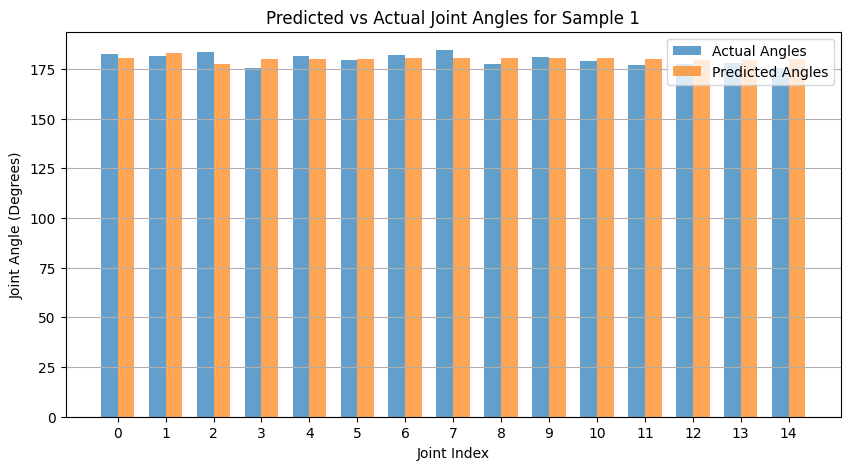

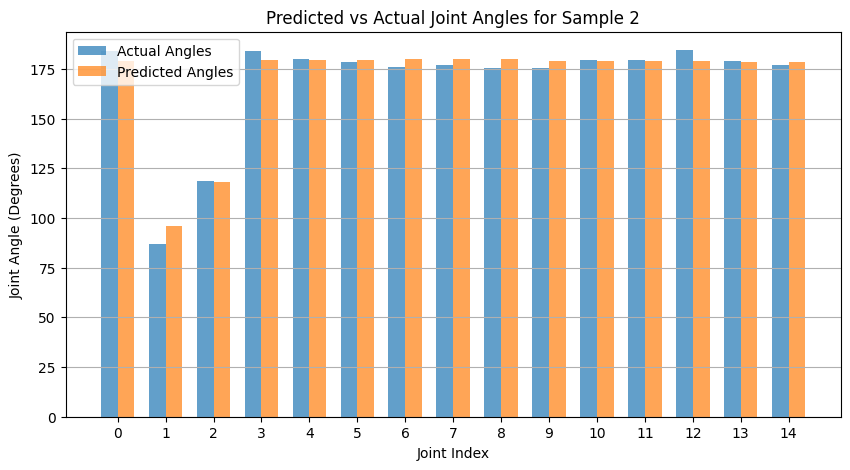

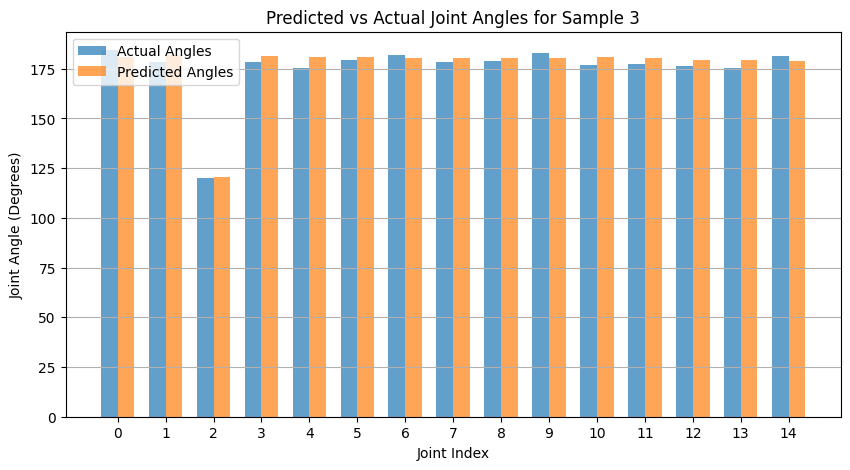

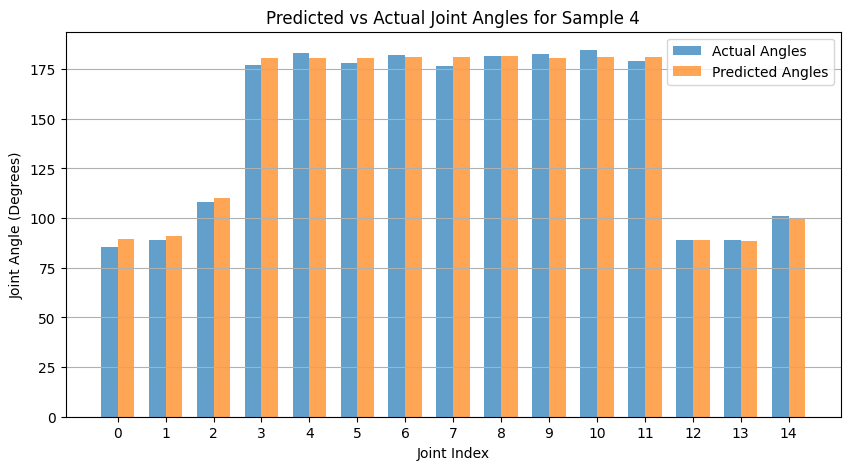

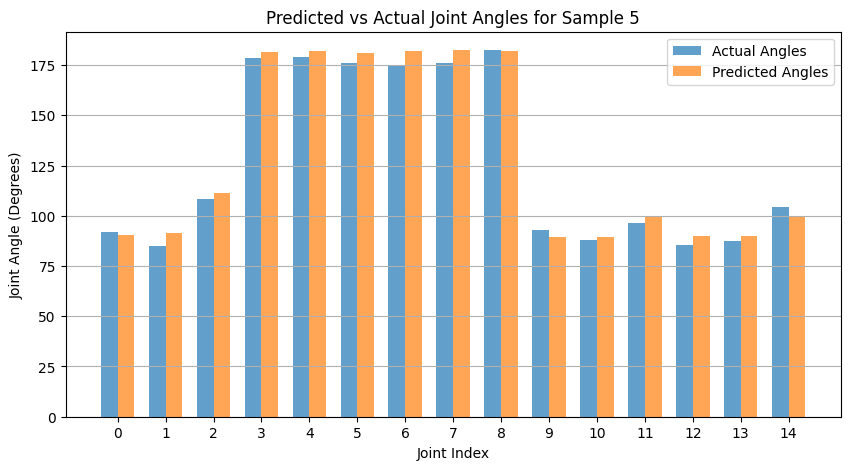

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Number of test samples to visualize
num_samples = 5

# Extract the first num_samples from test_loader
test_iter = iter(test_loader)
test_images, test_angles = next(test_iter)

test_images = test_images[:num_samples].to(device)
test_angles = test_angles[:num_samples].to(device)

# Make predictions
with torch.no_grad():
    predicted_angles = model(test_images)

# Convert to CPU for visualization
test_angles = test_angles.cpu().numpy()
predicted_angles = predicted_angles.cpu().numpy()

# ===============================
# ✅ PLOT PREDICTED VS ACTUAL ANGLES (BAR CHARTS)
# ===============================
for i in range(num_samples):
    fig, ax = plt.subplots(figsize=(10, 5))

    indices = np.arange(NUM_JOINTS)
    width = 0.35  # Width of the bars

    ax.bar(indices - width/2, test_angles[i], width, label="Actual Angles", alpha=0.7)
    ax.bar(indices + width/2, predicted_angles[i], width, label="Predicted Angles", alpha=0.7)

    ax.set_xlabel("Joint Index")
    ax.set_ylabel("Joint Angle (Degrees)")
    ax.set_title(f"Predicted vs Actual Joint Angles for Sample {i+1}")
    ax.set_xticks(indices)
    ax.legend()
    plt.grid(axis="y")

    plt.show()


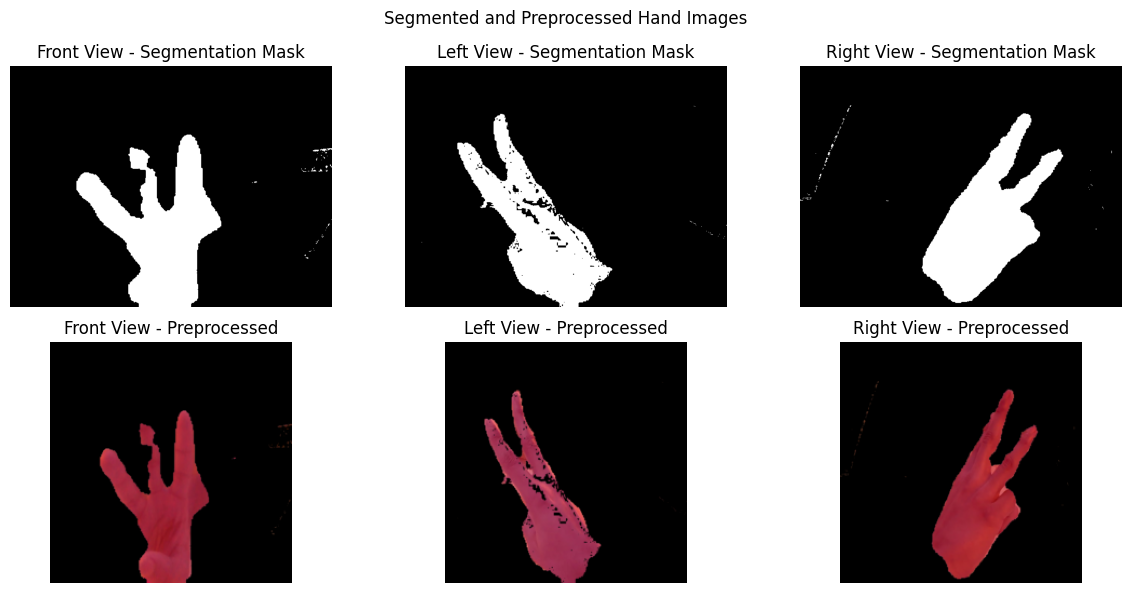

Input Tensor Shape (should be [1, 9, 224, 224]): torch.Size([1, 9, 224, 224])
Image Front View - Min: -1.0, Max: 0.6784313917160034
Image Left View - Min: -1.0, Max: 0.8901960849761963
Image Right View - Min: -1.0, Max: 0.6941176652908325


In [ ]:
import cv2
import torch
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# ===============================
# ✅ HAND SEGMENTATION FUNCTION (APPLIED TO UPLOADED IMAGES)
# ===============================
def extract_hand_region(segmented_image_path):
    """Extracts only the hand region from a segmented image using HSV thresholding."""
    image = cv2.imread(segmented_image_path)
    if image is None:
        print(f"❌ Warning: Could not read {segmented_image_path}")
        return np.zeros((224, 224, 3), dtype=np.uint8), np.zeros((224, 224), dtype=np.uint8)

    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_red1 = np.array([0, 120, 70])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 120, 70])
    upper_red2 = np.array([180, 255, 255])

    mask1 = cv2.inRange(image_hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(image_hsv, lower_red2, upper_red2)
    hand_mask = cv2.bitwise_or(mask1, mask2)

    hand_extracted = cv2.bitwise_and(image, image, mask=hand_mask)
    return hand_extracted, hand_mask

# ===============================
# ✅ APPLY PREPROCESSING TO UPLOADED IMAGES
# ===============================
# Define image paths (replace with actual paths)
image_paths = [
    "/content/gesture_dataset/gesture_34/frame_000_front_segmented.jpg",  # Front camera view
    "/content/gesture_dataset/gesture_34/frame_000_left_segmented.jpg",  # Left camera view
    "/content/gesture_dataset/gesture_34/frame_000_right_segmented.jpg"  # Right camera view
]

# Define transformation (matching dataset preprocessing)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Apply segmentation and preprocessing to each image
processed_images = []
segmented_masks = []
for img_path in image_paths:
    hand_extracted, hand_mask = extract_hand_region(img_path)
    hand_pil = Image.fromarray(cv2.cvtColor(hand_extracted, cv2.COLOR_BGR2RGB))
    processed_images.append(transform(hand_pil))
    segmented_masks.append(hand_mask)

# Concatenate images into a 9-channel tensor
input_tensor = torch.cat(processed_images, dim=0).unsqueeze(0)  # Shape: (1, 9, 224, 224)

# ===============================
# ✅ DISPLAY SEGMENTED HAND REGIONS
# ===============================
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

titles = ["Front View", "Left View", "Right View"]
for i in range(3):
    # Original Segmented Hand
    axes[0, i].imshow(cv2.cvtColor(segmented_masks[i], cv2.COLOR_GRAY2RGB))
    axes[0, i].axis("off")
    axes[0, i].set_title(f"{titles[i]} - Segmentation Mask")

    # Preprocessed Image (De-normalized for visualization)
    img_display = (processed_images[i] * 0.5 + 0.5).permute(1, 2, 0).cpu().numpy()
    axes[1, i].imshow(img_display)
    axes[1, i].axis("off")
    axes[1, i].set_title(f"{titles[i]} - Preprocessed")

plt.suptitle("Segmented and Preprocessed Hand Images")
plt.tight_layout()
plt.show()

# ===============================
# ✅ CHECK SHAPE CONSISTENCY
# ===============================
print("Input Tensor Shape (should be [1, 9, 224, 224]):", input_tensor.shape)

# ===============================
# ✅ CHECK VALUE RANGE
# ===============================
for i, img in enumerate(processed_images):
    print(f"Image {titles[i]} - Min: {img.min().item()}, Max: {img.max().item()}")


Predicted Joint Angles: [ 88.968796  90.655815 109.39076  180.92825  181.0895   180.47098
 181.50713  181.96536  181.70068  180.03848  180.2315   180.28186
  91.20043   90.76103  101.25026 ]


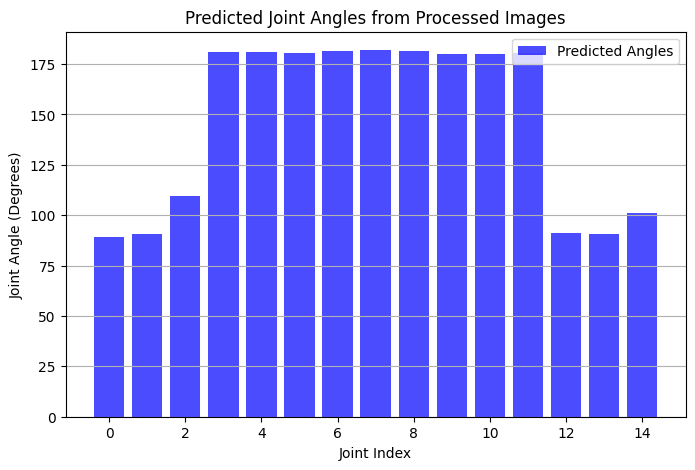

In [ ]:
# Ensure input tensor is on the same device as the model
input_tensor = input_tensor.to(device)

# Perform inference
with torch.no_grad():
    predicted_angles = model(input_tensor)

# Convert predictions to a readable format
predicted_angles = predicted_angles.cpu().numpy().flatten()

# Display results
print("Predicted Joint Angles:", predicted_angles)

# Plot predicted joint angles
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(range(NUM_JOINTS), predicted_angles, color='b', alpha=0.7, label="Predicted Angles")
ax.set_xlabel("Joint Index")
ax.set_ylabel("Joint Angle (Degrees)")
ax.set_title("Predicted Joint Angles from Processed Images")
ax.legend()
plt.grid(axis="y")
plt.show()


📂 Loading RGB dataset (raw images)...
✅ RGB Dataset Loaded: 5200 samples found
Preprocessing and caching RGB data...
✅ Cached RGB preprocessed data to cached_rgb_data.pt
🔹 Cached RGB Train Set: 4160 samples
🔹 Cached RGB Validation Set: 520 samples
🔹 Cached RGB Test Set: 520 samples


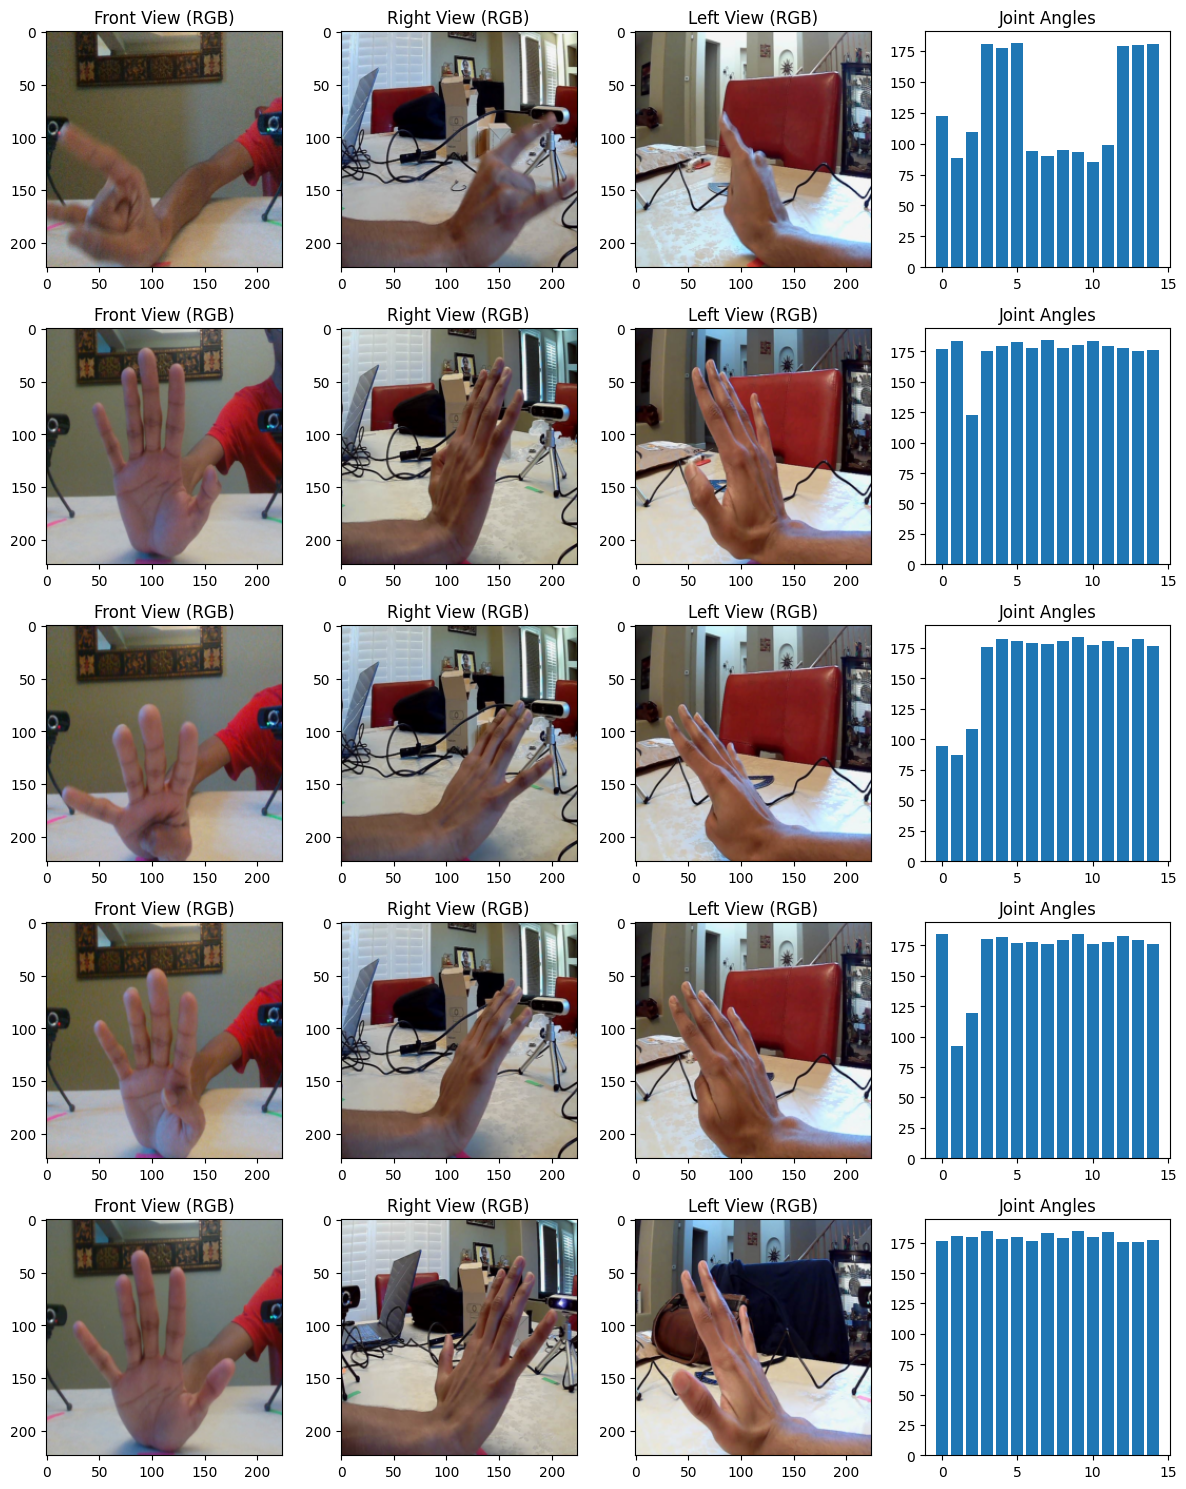

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import os
from PIL import Image
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ===============================
# ✅ CONFIGURATION
# ===============================
DATASET_PATH = "/content/gesture_dataset"
BATCH_SIZE = 64
IMAGE_SIZE = (224, 224)
NUM_JOINTS = 15
ACCURACY_THRESHOLD = 5  # ±5° accuracy range

# Cache paths (NEW cache for RGB data)
SEGMENTED_CACHE_FILE = "cached_gesture_data.pt"
RGB_CACHE_FILE = "cached_rgb_data.pt"

# ===============================
# ✅ RGB DATASET DEFINITION (For Student Model)
# ===============================
class RGBGestureDataset(Dataset):
    """
    Dataset for raw RGB images (no segmentation). This will be used for the student model.
    """
    def __init__(self, dataset_path, transform=None):
        self.dataset_path = dataset_path
        self.transform = transform
        self.data = []

        print("📂 Loading RGB dataset (raw images)...")

        gesture_folders = sorted(glob.glob(os.path.join(dataset_path, "gesture_*")))
        for gesture_folder in gesture_folders:
            angles_csv = os.path.join(gesture_folder, "angles.csv")
            if not os.path.exists(angles_csv):
                print(f"⚠️ Skipping {gesture_folder} (No angles.csv found)")
                continue

            df = pd.read_csv(angles_csv)
            for _, row in df.iterrows():
                frame_id = int(row["Frame"])
                joint_angles = row.iloc[1:].values.astype(float)

                # Raw RGB images (not segmented)
                front_rgb = os.path.join(gesture_folder, f"frame_{frame_id:03d}_front.jpg")
                right_rgb = os.path.join(gesture_folder, f"frame_{frame_id:03d}_right.jpg")
                left_rgb = os.path.join(gesture_folder, f"frame_{frame_id:03d}_left.jpg")

                if os.path.exists(front_rgb) and os.path.exists(right_rgb) and os.path.exists(left_rgb):
                    self.data.append((front_rgb, right_rgb, left_rgb, joint_angles))

        print(f"✅ RGB Dataset Loaded: {len(self.data)} samples found")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        front_rgb, right_rgb, left_rgb, joint_angles = self.data[idx]

        front_rgb = Image.open(front_rgb).convert("RGB")
        right_rgb = Image.open(right_rgb).convert("RGB")
        left_rgb = Image.open(left_rgb).convert("RGB")

        if self.transform:
            front_rgb = self.transform(front_rgb)
            right_rgb = self.transform(right_rgb)
            left_rgb = self.transform(left_rgb)

        # Concatenate the three views into one tensor with 9 channels
        images = torch.cat([front_rgb, right_rgb, left_rgb], dim=0)  # Shape: [9, 224, 224]

        return images, torch.tensor(joint_angles, dtype=torch.float32)

# ===============================
# ✅ DATA TRANSFORMATIONS
# ===============================
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create the RGB dataset
rgb_dataset = RGBGestureDataset(DATASET_PATH, transform)

# ===============================
# ✅ PREPROCESS & CACHE THE RGB DATA
# ===============================
if os.path.exists(RGB_CACHE_FILE):
    print(f"Loading cached RGB data from {RGB_CACHE_FILE}...")
    cached_rgb_data = torch.load(RGB_CACHE_FILE)
else:
    print("Preprocessing and caching RGB data...")
    cached_rgb_data = []
    for i in range(len(rgb_dataset)):
        sample = rgb_dataset[i]
        cached_rgb_data.append(sample)
    torch.save(cached_rgb_data, RGB_CACHE_FILE)
    print(f"✅ Cached RGB preprocessed data to {RGB_CACHE_FILE}")

# ===============================
# ✅ CACHED DATASET DEFINITION (RGB)
# ===============================
class CachedRGBGestureDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

cached_rgb_dataset = CachedRGBGestureDataset(cached_rgb_data)

# ===============================
# ✅ SPLITTING THE CACHED RGB DATASET
# ===============================
train_size = int(0.8 * len(cached_rgb_dataset))
val_size = int(0.1 * len(cached_rgb_dataset))
test_size = len(cached_rgb_dataset) - train_size - val_size
train_rgb_dataset, val_rgb_dataset, test_rgb_dataset = random_split(cached_rgb_dataset, [train_size, val_size, test_size])

print(f"🔹 Cached RGB Train Set: {len(train_rgb_dataset)} samples")
print(f"🔹 Cached RGB Validation Set: {len(val_rgb_dataset)} samples")
print(f"🔹 Cached RGB Test Set: {len(test_rgb_dataset)} samples")

# ===============================
# ✅ CREATING DATALOADERS FROM THE CACHED RGB DATASET
# ===============================
train_rgb_loader = DataLoader(train_rgb_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_rgb_loader = DataLoader(val_rgb_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_rgb_loader = DataLoader(test_rgb_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ===============================
# ✅ DEBUG: VISUALIZE SAMPLE DATA FROM CACHED RGB DATASET
# ===============================
def visualize_samples_rgb(dataset, num_samples=5):
    """
    Displays raw RGB hand images along with joint angles.
    """
    fig, axes = plt.subplots(num_samples, 4, figsize=(12, num_samples * 3))
    for i in range(num_samples):
        images, angles = dataset[i]
        front_img = images[:3].permute(1, 2, 0).numpy() * 0.5 + 0.5  # De-Normalize
        right_img = images[3:6].permute(1, 2, 0).numpy() * 0.5 + 0.5
        left_img = images[6:9].permute(1, 2, 0).numpy() * 0.5 + 0.5

        axes[i, 0].imshow(front_img)
        axes[i, 0].set_title("Front View (RGB)")
        axes[i, 1].imshow(right_img)
        axes[i, 1].set_title("Right View (RGB)")
        axes[i, 2].imshow(left_img)
        axes[i, 2].set_title("Left View (RGB)")
        axes[i, 3].bar(range(NUM_JOINTS), angles.numpy())
        axes[i, 3].set_title("Joint Angles")
    plt.tight_layout()
    plt.show()

# Display 5 sample images and their joint angles from the cached RGB training dataset
visualize_samples_rgb(train_rgb_dataset, num_samples=5)


In [ ]:
from torch.utils.data import DataLoader, random_split

# Assume CACHE_FILE and CachedGestureDataset are defined from previous caching code:
# For example:
# CACHE_FILE = "cached_gesture_data.pt"
# cached_data = torch.load(CACHE_FILE)
# cached_dataset = CachedGestureDataset(cached_data)

# Split the cached dataset: 80% train, 10% validation, 10% test
total_samples = len(cached_rgb_dataset)
train_size = int(0.8 * total_samples)
val_size = int(0.1 * total_samples)
test_size = total_samples - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(cached_rgb_dataset, [train_size, val_size, test_size])

print(f"Cached Train Set: {len(train_dataset)} samples")
print(f"Cached Validation Set: {len(val_dataset)} samples")
print(f"Cached Test Set: {len(test_dataset)} samples")

# Create DataLoaders without re-running the segmentation
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Cached Train Set: 4160 samples
Cached Validation Set: 520 samples
Cached Test Set: 520 samples


In [ ]:
# Fetch one sample from the cached dataset
sample_images, sample_angles = cached_rgb_dataset[0]

print("Sample image shape:", sample_images.shape)  # Expected: torch.Size([9, 224, 224])
print("Sample joint angles shape:", sample_angles.shape)  # Expected: torch.Size([15])


Sample image shape: torch.Size([9, 224, 224])
Sample joint angles shape: torch.Size([15])


In [ ]:
import torch
torch.cuda.empty_cache()  # ✅ Frees up cached memory


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()
